Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Types of Recurrent Neural Networks**<br/>
![Alt text](1-2.jpg)  ![Alt text](2-2.jpg)

c:\Users\Reza\Documents\Deep-Learning-in-python\New folder\Images\1.jpg

================================== Importing the required Libraries ===========================

In [55]:
import os
import sys
import math
import gluonts 
import numpy as np
import pandas as pd

import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, SimpleRNN, LSTM

from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestMean
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions

ModuleNotFoundError: No module named 'mxnet'

========================================= Functions ==================================

In [25]:
# =============================================== Preparing data =====================================================
def Prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=2, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # --------------------------------------------- Step 1.3: Data Splitting -----------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    dat_train = data.iloc[0:n,:]
    data_train = dat_train.values.reshape(-1,1)
    
    dat_test = data.iloc[data_train.shape[0]-x_steps:,:]
    data_test = dat_test.values.reshape(-1,1)
    # !============================================== Step 2: Scaling ================================================
    mod = MinMaxScaler(feature_range=(0, 1))
    data_train = mod.fit_transform(data_train)
    data_test = mod.transform(data_test)
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, dat_train, dat_test, mod

# ============================================= Plot prediction ======================================================
def plot_prediction(data_train, data_test, pred_train, pred_test, mod):
    
    _, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))
    # axs[0].plot(data.iloc[0:pred_train.shape[0],:], label='Train data')
    axs[0].plot(data_train, label='Train data')
    axs[0].plot(data_train.index[:pred_train.shape[0]], mod.inverse_transform(pred_train[:,0].reshape(-1,1)), label='Estimate')
    axs[0].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[1].plot(data_test, label='Test data')
    axs[1].plot(data_test.index[:pred_test.shape[0]:], mod.inverse_transform(pred_test[:,0].reshape(-1,1)), label='Estimate')
    axs[1].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[0].autoscale(enable=True, axis="x",tight=True)
    axs[1].autoscale(enable=True, axis="x",tight=True)
    plt.subplots_adjust(wspace=0.04, hspace=0.2)
    
# ====================================== Plot loss for train & test ==================================================   
def plot_loss(train_model):
    _, axs = plt.subplots(nrows=1, sharey='row', figsize=(4, 3))
    axs.plot(train_model.history["loss"], label='training loss')
    axs.plot(train_model.history["val_loss"], label='validation loss',)
    axs.legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)
    axs.autoscale(enable=True, axis="x",tight=True)
    axs.set_xlabel('Epochs', fontsize=10)

*Step 1.1: Load Data*

In [26]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [27]:
data = Prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

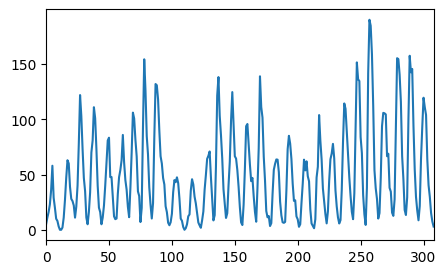

In [28]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Creating sequences*

In [29]:
x_steps = 6
y_steps = 2
x_train, y_train, x_test, y_test, data_train, data_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3.1: Creating the Simple [RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) Model using:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>

*inputs $\Rightarrow$ Preparing 3-Dimensional Input for Sequential Model, with shape [batch, timesteps, feature].*<br/>
![Alt text](<Simple RNN.png>)    ![Alt text](<Simple RNN 1.png>)

In [30]:
model = Sequential([SimpleRNN(50, return_sequences=True),
                            SimpleRNN(50),
                            Dense(y_steps)])
model.layers                                 # Print the model parameters

*Step 3.2: [Model compile](https://keras.io/api/models/model_training_apis/)*<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>

In [31]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])  # Regression:mean_squared_error

*Step 3.3: Training the Model*<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

In [32]:
train_model = model.fit(x_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
5/5 [==============================] - 5s 161ms/step - loss: 0.1253 - mean_absolute_error: 0.2754 - val_loss: 0.0994 - val_mean_absolute_error: 0.2667
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0596 - mean_absolute_error: 0.1972 - val_loss: 0.0526 - val_mean_absolute_error: 0.1764
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0407 - mean_absolute_error: 0.1462 - val_loss: 0.0369 - val_mean_absolute_error: 0.1361
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0337 - mean_absolute_error: 0.1375 - val_loss: 0.0365 - val_mean_absolute_error: 0.1465
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0298 - mean_absolute_error: 0.1387 - val_loss: 0.0345 - val_mean_absolute_error: 0.1334
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0315 - mean_absolute_error: 0.1268 - val_loss: 0.0323 - val_mean_absolute_error: 0.1339
Epoch 7/100
5/5 [==========

*Step 3.4: Predicting for train & test data*

In [33]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

4/4 [==============================] - 0s 3ms/step


*Calculating the correctness for train & test data*

*Plot of Training and Test Loss Functions*

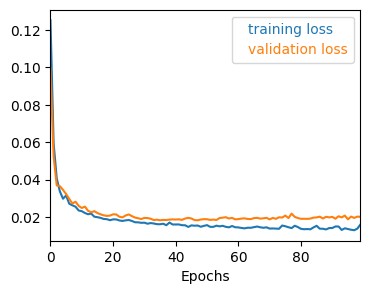

In [34]:
plot_loss(train_model)

*Plot of actuals and predictions for train & test data*

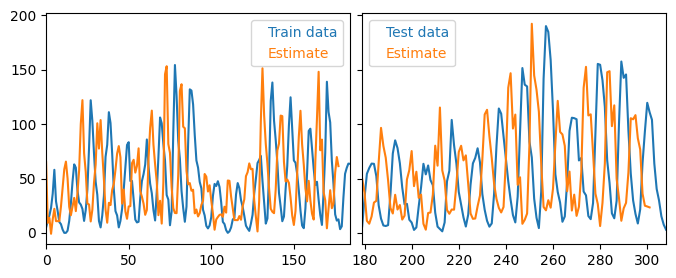

In [35]:
plot_prediction(data_train, data_test, pred_train, pred_test, mod)

*[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)*

Epoch 1/100
5/5 [==============================] - 15s 389ms/step - loss: 0.1209 - mean_absolute_error: 0.2627 - val_loss: 0.1264 - val_mean_absolute_error: 0.2795
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0903 - mean_absolute_error: 0.2149 - val_loss: 0.0943 - val_mean_absolute_error: 0.2451
Epoch 3/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0688 - mean_absolute_error: 0.2005 - val_loss: 0.0749 - val_mean_absolute_error: 0.2281
Epoch 4/100
5/5 [==============================] - 0s 31ms/step - loss: 0.0633 - mean_absolute_error: 0.2085 - val_loss: 0.0722 - val_mean_absolute_error: 0.2285
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0623 - mean_absolute_error: 0.2090 - val_loss: 0.0681 - val_mean_absolute_error: 0.2168
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0582 - mean_absolute_error: 0.1973 - val_loss: 0.0663 - val_mean_absolute_error: 0.2093
Epoch 7/100
5/5 [=========

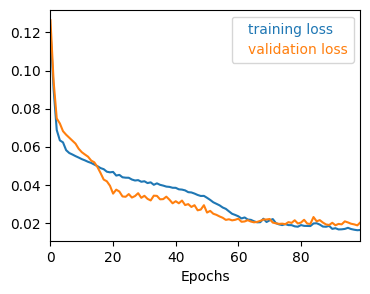

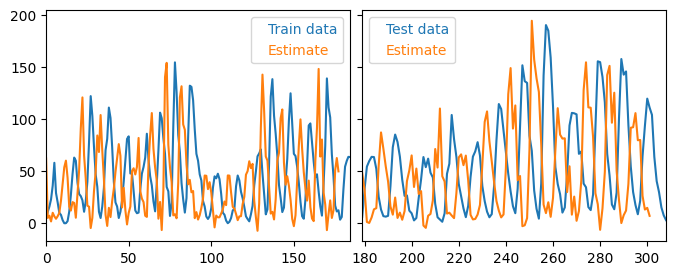

In [36]:
model = Sequential([LSTM(50, return_sequences=True),
                   LSTM(50),
                   Dense(y_steps)])
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])  # Regression:mean_squared_error
train_model = model.fit(x_train, y_train, epochs=100, validation_split=0.15)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
plot_loss(train_model)
plot_prediction(data_train, data_test, pred_train, pred_test, mod)

*[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)*<br/>
[Article](https://arxiv.org/pdf/1406.1078.pdf)

*[GluonTS](https://www.selvai.com/probabilistic_time_series_modeling.html)*

In [51]:
n = math.floor(data.shape[0] * 0.7)
train_data = ListDataset([{"start":data.index[0], "target":data.iloc[0:n,:]}], freq="H")

GluonTSDataError: Error "day is out of range for month: 0" occurred, when reading field "start"

In [54]:
# from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestMean
from gluonts.mx.trainer import Trainer


ModuleNotFoundError: No module named 'mxnet'

In [39]:
data

,SUNACTIVITY
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0
...,...
304,40.4
305,29.8
306,15.2
307,7.5
